In [1]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/dataset1/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/dataset1


In [3]:
from torchvision.datasets import VOCSegmentation
from torchvision.transforms.functional import to_tensor,to_pil_image
from PIL import Image
import os
import copy
from torch.utils.data import Dataset
import torch
import numpy as np
from skimage.segmentation import mark_boundaries
import matplotlib.pylab as plt
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.optim as optim
import albumentations
from torch import nn
from torch import optim
from torchsummary import summary
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Reading data

In [4]:
TRAINING_IMAGE = "images_prepped_train/"
TRAINING_MASK = "annotations_prepped_train/"
VALIDATION_IMAGE = "images_prepped_test/"
VALIDATION_MASK = "annotations_prepped_test/"

In [5]:
class CitySpace_Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)

        if self.transform is not None:
          augmented= self.transform(image=np.array(img),
          mask=np.array(mask))
          img = augmented['image']
          mask = augmented['mask']
          mask[mask>11]=0

          img= to_tensor(img)
          mask= torch.from_numpy(mask).type(torch.long)

        return img,mask

In [6]:
#Data Augmentation
train_transform = albumentations.Compose(
        [
            albumentations.Resize(height=224, width=224),
            albumentations.Rotate(limit=35, p=1.0),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.1),
            albumentations.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
        ],
    )
val_transform = albumentations.Compose(
        [
            albumentations.Resize(height=224, width=224),
            albumentations.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
        ],
    )

In [7]:
train_ds=CitySpace_Dataset( image_dir=TRAINING_IMAGE,mask_dir=TRAINING_MASK,
 transform=train_transform)
val_ds=CitySpace_Dataset( image_dir=VALIDATION_IMAGE,mask_dir=VALIDATION_MASK,
 transform=val_transform)

In [8]:
%matplotlib inline
np.random.seed(0)
num_classes=11
COLORS = np.random.randint(0, 2, size=(num_classes+1,
3),dtype="uint8")

In [9]:
#Image Visualization
def show_img_target(img, target):
    if torch.is_tensor(img):
      img=to_pil_image(img)
      target=target.numpy()
    for ll in range(num_classes):
      mask=(target==ll)
      img=mark_boundaries(np.array(img),mask,outline_color=COLORS[ll],color=COLORS[ll])
    plt.imshow(img)

def re_normalize (x, mean = [0.0, 0.0, 0.0], std= [1.0, 1.0, 1.0]):
   x_r= x.clone()
   for c, (mean_c, std_c) in enumerate(zip(mean, std)):
     x_r [c] *= std_c
     x_r [c] += mean_c
     return x_r

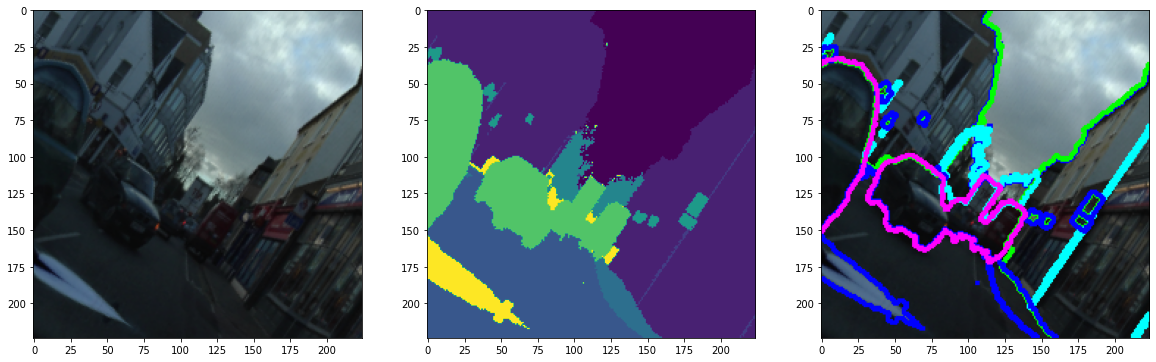

In [10]:
img, mask = train_ds[11]
plt.figure(figsize=(20,20))
img_r= re_normalize(img)
plt.subplot(1, 3, 1)
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.subplot(1, 3, 3)
show_img_target(img_r, mask)

In [11]:
#Data Loader


train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False)

# Metrics Definition

In [12]:
def dice_loss1(input, target):
    smooth = 1.
    input=torch.argmax(input, dim=1)
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth)).item()

def iou(outputs, labels):
    SMOOTH= 1e-6
    outputs=torch.argmax(outputs, dim=1)
    
    intersection = (outputs & labels).float().sum((1, 2)) 
    union = (outputs | labels).float().sum((1, 2))         
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    mean_iou=torch.sum(iou)/4 
    return mean_iou.item()

def metrics_batch(pred, target):
  pred=torch.argmax(pred, dim=1)
  metric=dice_loss1(pred, target)
  return metric

def loss_batch(loss_func, output, target, opt=None):
 loss = loss_func(output, target)

 with torch.no_grad():
        metric_b=dice_loss1(output, target)
        iou_score=iou(output,target)

 if opt is not None:
   opt.zero_grad()
   loss.backward()
   opt.step()
 return loss.item(), metric_b,iou_score

def get_lr(opt):
 for param_group in opt.param_groups:
   return param_group['lr']


In [13]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
 running_loss=0.0
 running_metric=0.0
 running_iou=0.0
 len_data=len(dataset_dl.dataset)
 for xb, yb in dataset_dl:
   output=model(xb)
   loss_b, metric_b,iou_score = loss_batch(loss_func, output, yb, opt)
   running_loss += loss_b

   if metric_b is not None:
     running_metric+=metric_b
     if iou_score is not None:
      running_iou+=metric_b
   if sanity_check is True:
     break
 loss=running_loss/float(len_data)
 metric=running_metric/float(len_data)
 iou=running_iou/float(len_data)
 return loss, metric,iou

def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": []}
    
    metric_history={
        "train": [],
        "val": []}
    iou_history={
        "train": [],
        "val": []}  
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')    
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        model.train()
        train_loss, train_metric,train_iou=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        iou_history["train"].append(train_iou)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric,val_iou=loss_epoch(model,loss_func,val_dl,sanity_check)
       
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        iou_history["val"].append(val_iou)   
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            
        print("train loss: %.6f" %(train_loss))
        print("val loss: %.6f" %(val_loss))
        print("-"*10) 
        print(f"Trainig Dice Score {train_metric}")
        print(f"Validation Dice Score {val_metric}")
        print(f"Trainig IOU Score {train_iou}")
        print(f"Validation IOU Score {val_iou}")
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history,iou_history

# Model 1

In [14]:
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 12
ACTIVATION = 'sigmoid'

deepLabV3 = smp.DeepLabV3(
    encoder_weights = ENCODER_WEIGHTS,
    classes = CLASSES, 
    activation = ACTIVATION)

In [15]:
summary(deepLabV3, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [17]:
opt = optim.Adam(deepLabV3.parameters(), lr=1e-6)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "./model_weights/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 50,
    "optimizer": opt,
    "loss_func": criterion,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"deeplab_weights.pt",
}

deepLabV3, loss_hist,metric_his,iou_his = train_val(deepLabV3, params_train)

Epoch 0/49, current lr=1e-06
Copied best model weights!
train loss: 1350.926856
val loss: 9866.920173
----------
Trainig Dice Score 0.01068531589871856
Validation Dice Score 0.03933207115324417
Trainig IOU Score 0.01068531589871856
Validation IOU Score 0.03933207115324417
Epoch 1/49, current lr=1e-06
Copied best model weights!
train loss: 1348.240208
val loss: 9865.975248
----------
Trainig Dice Score 0.010265883697800805
Validation Dice Score 0.041974629506026165
Trainig IOU Score 0.010265883697800805
Validation IOU Score 0.041974629506026165
Epoch 2/49, current lr=1e-06
Copied best model weights!
train loss: 1348.175409
val loss: 9865.800124
----------
Trainig Dice Score 0.009784464615242358
Validation Dice Score 0.04365614617224967
Trainig IOU Score 0.009784464615242358
Validation IOU Score 0.04365614617224967
Epoch 3/49, current lr=1e-06
Copied best model weights!
train loss: 1347.587108
val loss: 9864.772277
----------
Trainig Dice Score 0.011155935334249804
Validation Dice Score 

Evaluation

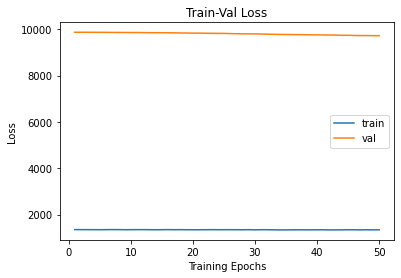

In [18]:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

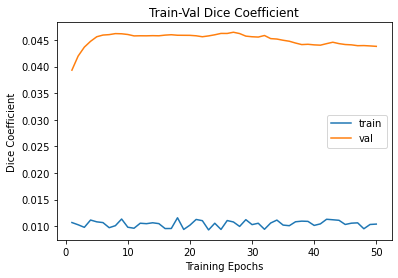

In [19]:
plt.title("Train-Val Dice Coefficient")
plt.plot(range(1,num_epochs+1),metric_his["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_his["val"],label="val")
plt.ylabel("Dice Coefficient")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

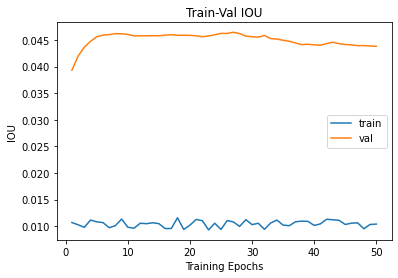

In [20]:
plt.title("Train-Val IOU")
plt.plot(range(1,num_epochs+1),iou_his["train"],label="train")
plt.plot(range(1,num_epochs+1),iou_his["val"],label="val")
plt.ylabel("IOU")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

Qualitative results

In [21]:
def get_prediction(img):
  img=torch.unsqueeze(img, 0)
  prediction=deepLabV3(img)
  prediction = torch.nn.functional.softmax(prediction, dim=1)
  prediction=torch.squeeze(prediction)
  prediction=torch.argmax(prediction, dim=0)
  return prediction

In [22]:
img_1, mask_1 = val_ds[11]
img_2, mask_2 = val_ds[22]
img_3, mask_3 = val_ds[33]
img_4, mask_4 = val_ds[44]

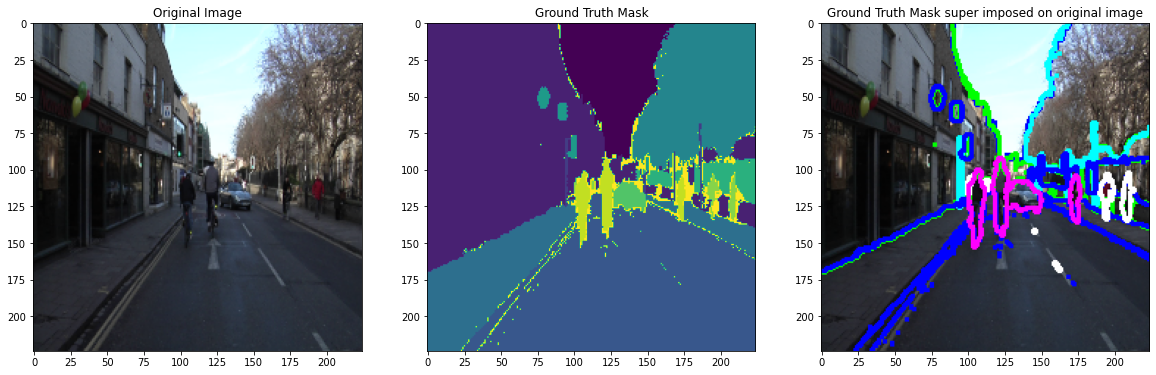

In [23]:
pred_1=get_prediction(img_1)
plt.figure(figsize=(20,20))
img_r= re_normalize(img_1)
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(mask_1)
plt.subplot(1, 3, 3)
plt.title('Ground Truth Mask super imposed on original image')
show_img_target(img_r, mask_1)

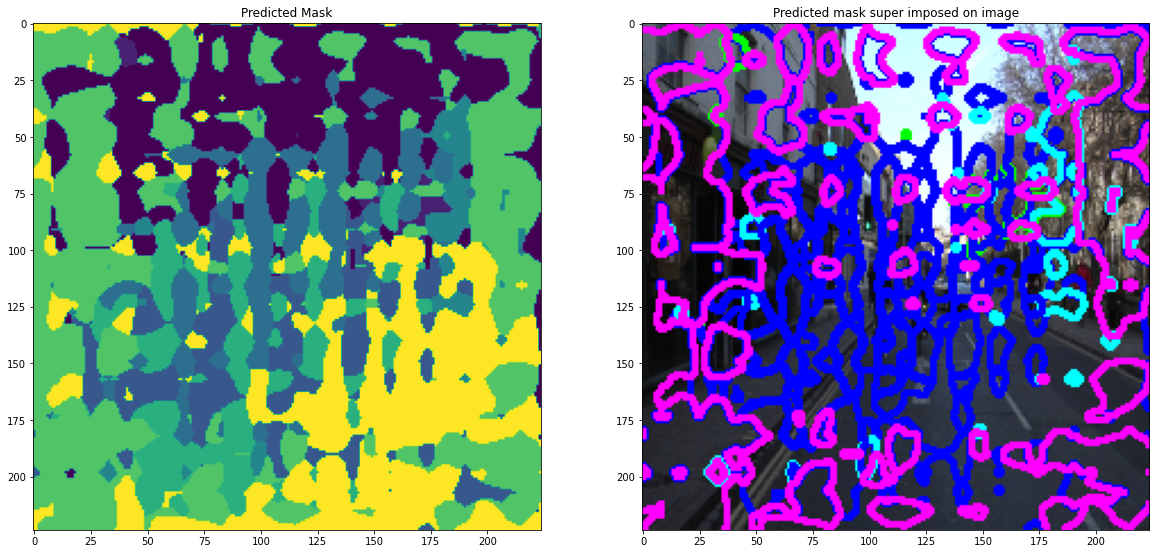

In [24]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_1)
plt.subplot(1, 2, 2)
plt.title('Predicted mask super imposed on image')
show_img_target(img_r, pred_1)

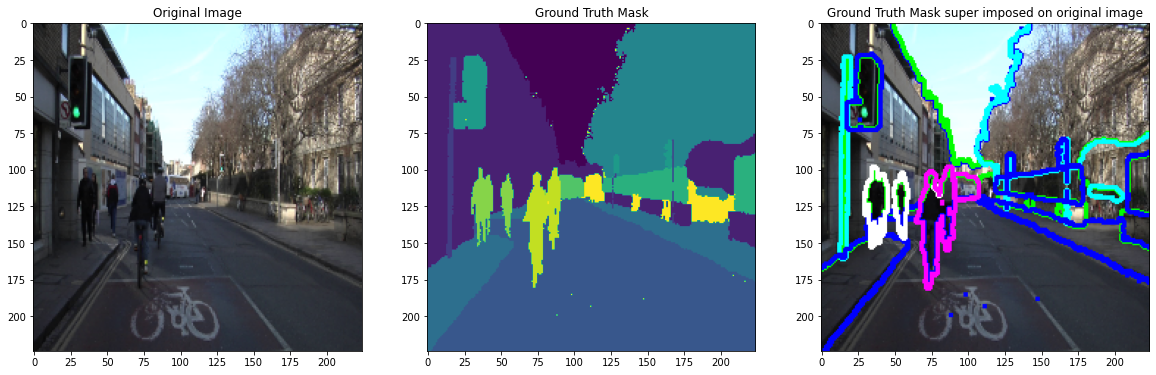

In [25]:
pred_2=get_prediction(img_2)
plt.figure(figsize=(20,20))
img_r= re_normalize(img_2)
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(mask_2)
plt.subplot(1, 3, 3)
plt.title('Ground Truth Mask super imposed on original image')
show_img_target(img_r, mask_2)

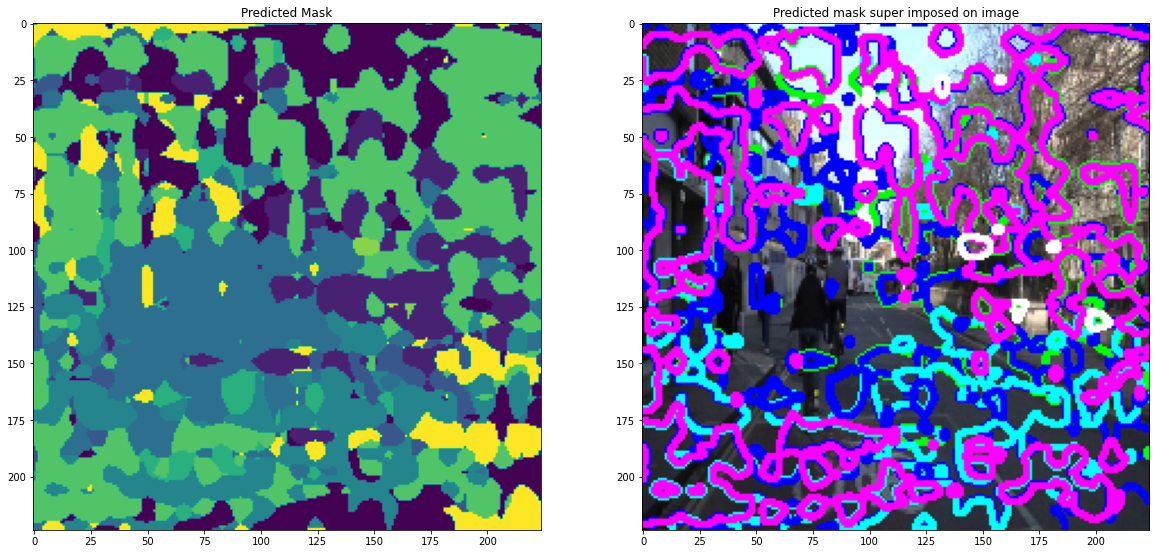

In [26]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_2)
plt.subplot(1, 2, 2)
plt.title('Predicted mask super imposed on image')
show_img_target(img_r, pred_2)

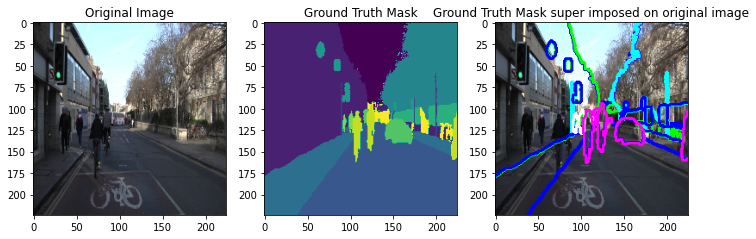

In [27]:
pred_3=get_prediction(img_3)
plt.figure(figsize=(20,20))
img_r= re_normalize(img_2)
plt.subplot(1, 5, 1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 5, 2)
plt.title('Ground Truth Mask')
plt.imshow(mask_3)
plt.subplot(1, 5, 3)
plt.title('Ground Truth Mask super imposed on original image')
show_img_target(img_r, mask_3)

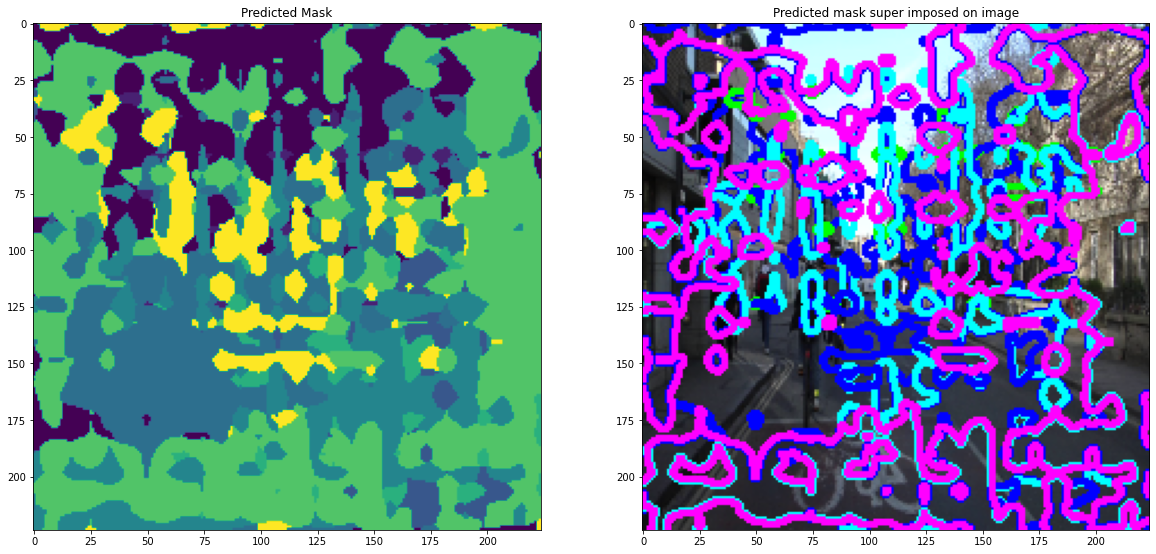

In [28]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_3)
plt.subplot(1, 2, 2)
plt.title('Predicted mask super imposed on image')
show_img_target(img_r, pred_3)

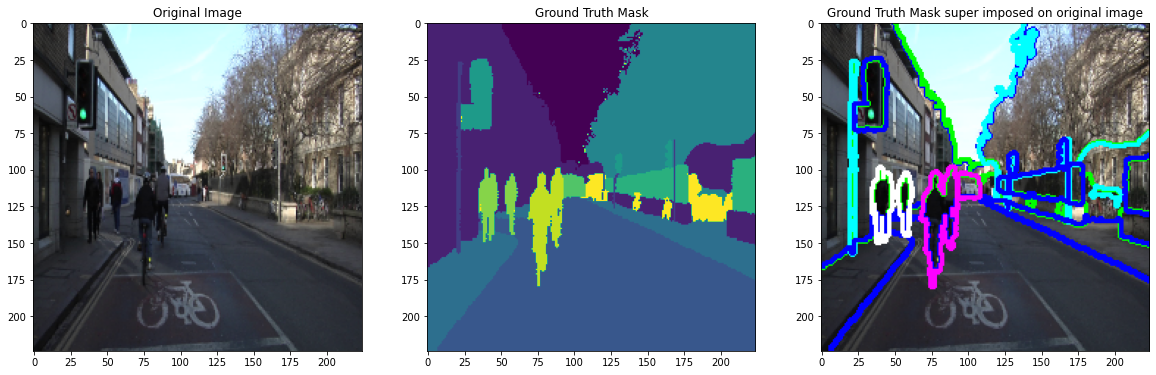

In [29]:
pred_4=get_prediction(img_4)
plt.figure(figsize=(20,20))
img_r= re_normalize(img_4)
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(mask_4)
plt.subplot(1, 3, 3)
plt.title('Ground Truth Mask super imposed on original image')
show_img_target(img_r, mask_4)

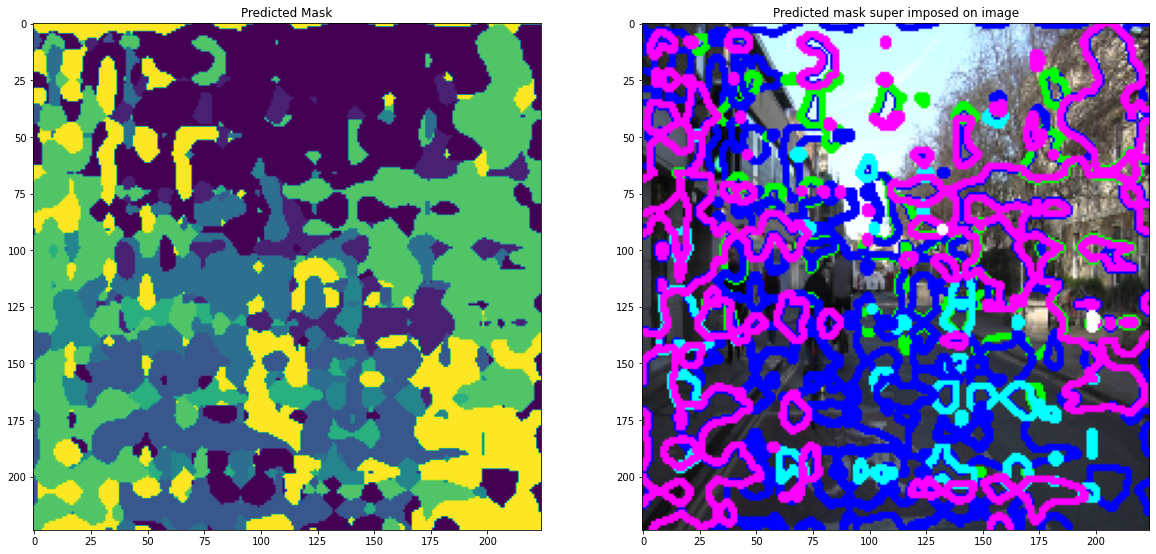

In [30]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_4)
plt.subplot(1, 2, 2)
plt.title('Predicted mask super imposed on image')
show_img_target(img_r, pred_4)

# Model 2

In [56]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 12
ACTIVATION = 'sigmoid'

deepLabV3_mobilenet = smp.DeepLabV3(
    encoder_name = ENCODER,
    encoder_weights = ENCODER_WEIGHTS,
    classes = CLASSES, 
    activation = ACTIVATION)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [57]:
summary(deepLabV3_mobilenet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [58]:
criterion = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(deepLabV3_mobilenet.parameters(), lr=3E-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5,
patience=20,verbose=1)
current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


In [59]:
opt = optim.Adam(deepLabV3_mobilenet.parameters(), lr=1e-6)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "./model_weights/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 10,
    "optimizer": opt,
    "loss_func": criterion,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"deeplabmobilenet_weights.pt",
}

deeplabV3_mobilenet, loss_hist,metric_his,iou_his = train_val(deepLabV3_mobilenet, params_train)

Epoch 0/9, current lr=1e-06
Copied best model weights!
train loss: 1363.754939
val loss: 9873.476485
----------
Trainig Dice Score 0.01050767067017932
Validation Dice Score 0.04233325826059474
Trainig IOU Score 0.01050767067017932
Validation IOU Score 0.04233325826059474
Epoch 1/9, current lr=1e-06
Copied best model weights!
train loss: 1358.465344
val loss: 9869.563738
----------
Trainig Dice Score 0.011211160093302298
Validation Dice Score 0.044453096861886504
Trainig IOU Score 0.011211160093302298
Validation IOU Score 0.044453096861886504
Epoch 2/9, current lr=1e-06
Copied best model weights!
train loss: 1358.852520
val loss: 9865.109530
----------
Trainig Dice Score 0.010660185151269066
Validation Dice Score 0.045776636293618986
Trainig IOU Score 0.010660185151269066
Validation IOU Score 0.045776636293618986
Epoch 3/9, current lr=1e-06
Copied best model weights!
train loss: 1356.878661
val loss: 9860.431312
----------
Trainig Dice Score 0.01134369743617419
Validation Dice Score 0.0

Evaluation

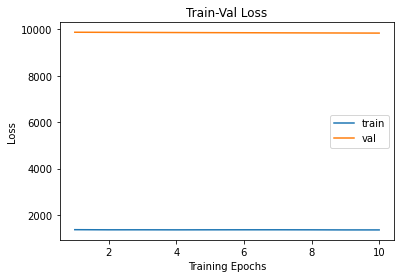

In [60]:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

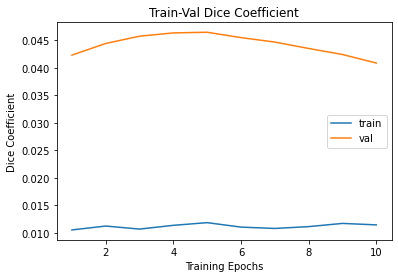

In [61]:
plt.title("Train-Val Dice Coefficient")
plt.plot(range(1,num_epochs+1),metric_his["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_his["val"],label="val")
plt.ylabel("Dice Coefficient")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

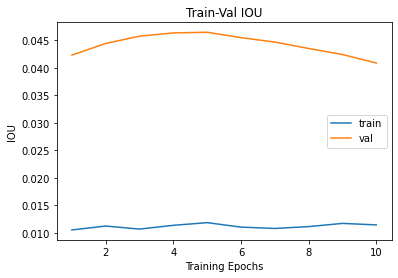

In [62]:
plt.title("Train-Val IOU")
plt.plot(range(1,num_epochs+1),iou_his["train"],label="train")
plt.plot(range(1,num_epochs+1),iou_his["val"],label="val")
plt.ylabel("IOU")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

Qualitative results

In [63]:
def get_prediction(img):
  img=torch.unsqueeze(img, 0)
  prediction=deepLabV3_mobilenet(img)
  prediction = torch.nn.functional.softmax(prediction, dim=1)
  prediction=torch.squeeze(prediction)
  prediction=torch.argmax(prediction, dim=0)
  return prediction

In [64]:
img_1, mask_1 = val_ds[11]
img_2, mask_2 = val_ds[22]
img_3, mask_3 = val_ds[33]
img_4, mask_4 = val_ds[44]

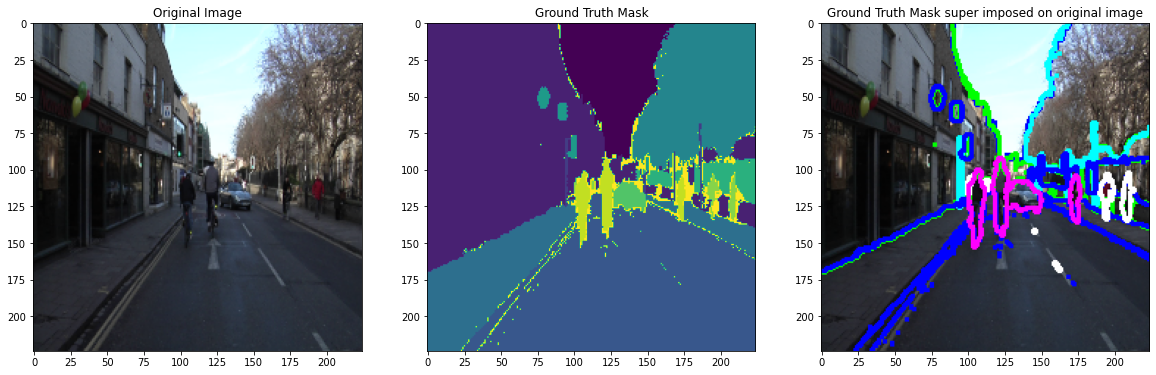

In [65]:
pred_1=get_prediction(img_1)
plt.figure(figsize=(20,20))
img_r= re_normalize(img_1)
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(mask_1)
plt.subplot(1, 3, 3)
plt.title('Ground Truth Mask super imposed on original image')
show_img_target(img_r, mask_1)

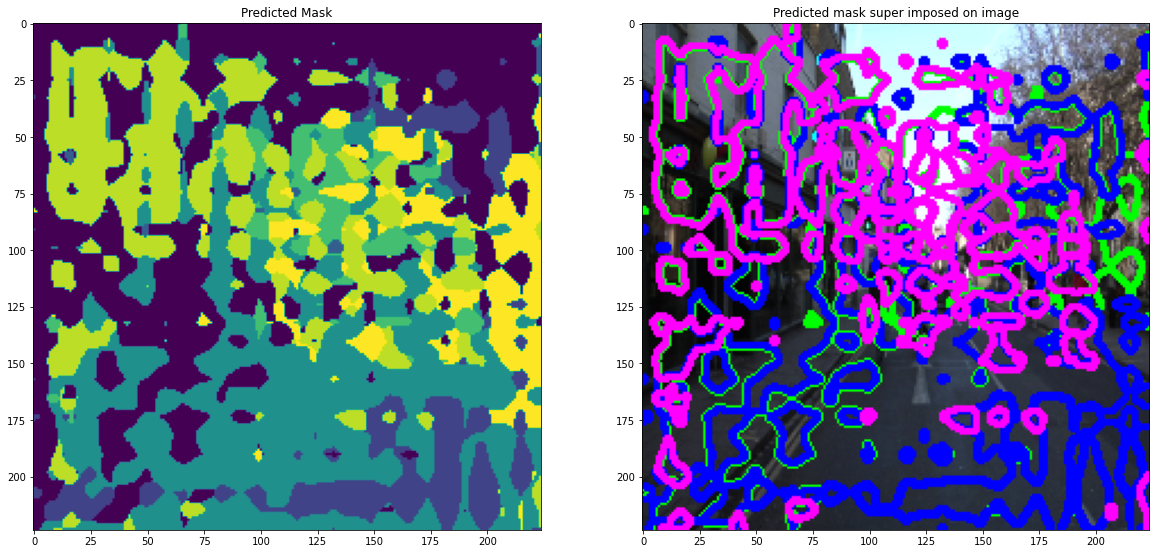

In [66]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_1)
plt.subplot(1, 2, 2)
plt.title('Predicted mask super imposed on image')
show_img_target(img_r, pred_1)

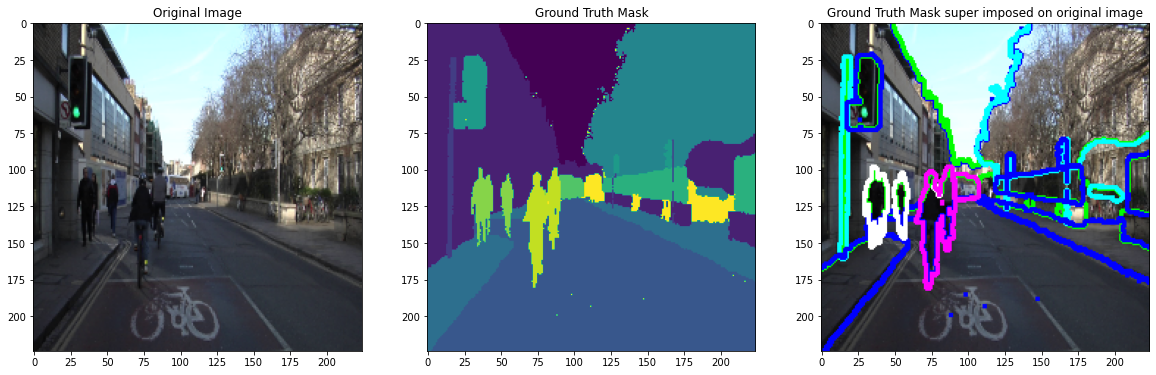

In [67]:
pred_2=get_prediction(img_2)
plt.figure(figsize=(20,20))
img_r= re_normalize(img_2)
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(mask_2)
plt.subplot(1, 3, 3)
plt.title('Ground Truth Mask super imposed on original image')
show_img_target(img_r, mask_2)

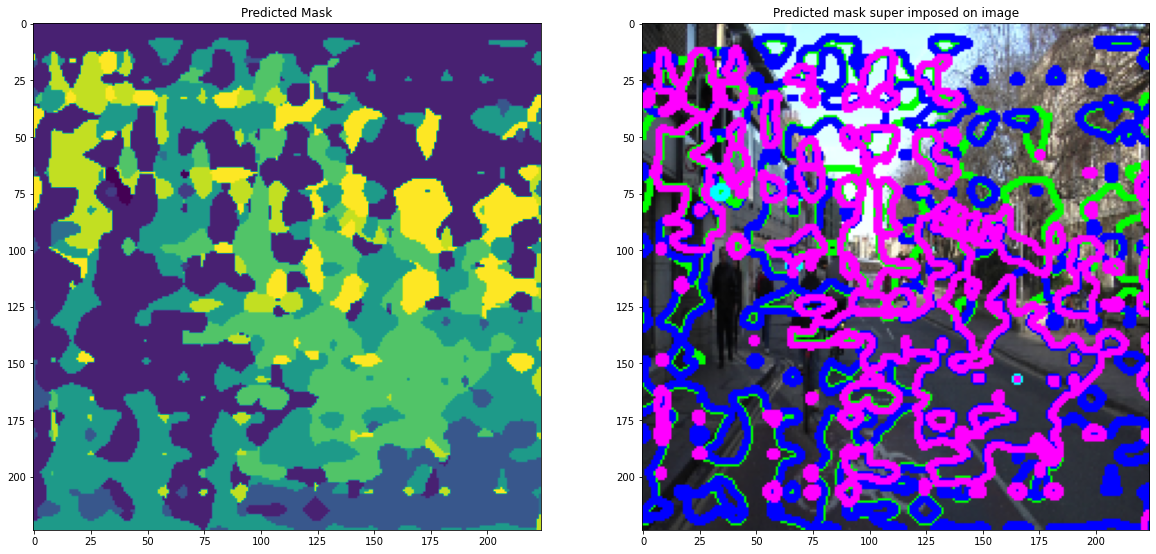

In [68]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_2)
plt.subplot(1, 2, 2)
plt.title('Predicted mask super imposed on image')
show_img_target(img_r, pred_2)

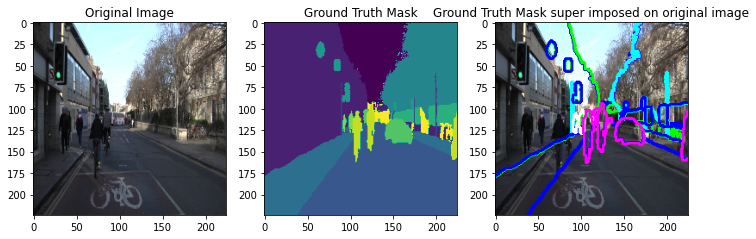

In [69]:
pred_3=get_prediction(img_3)
plt.figure(figsize=(20,20))
img_r= re_normalize(img_2)
plt.subplot(1, 5, 1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 5, 2)
plt.title('Ground Truth Mask')
plt.imshow(mask_3)
plt.subplot(1, 5, 3)
plt.title('Ground Truth Mask super imposed on original image')
show_img_target(img_r, mask_3)

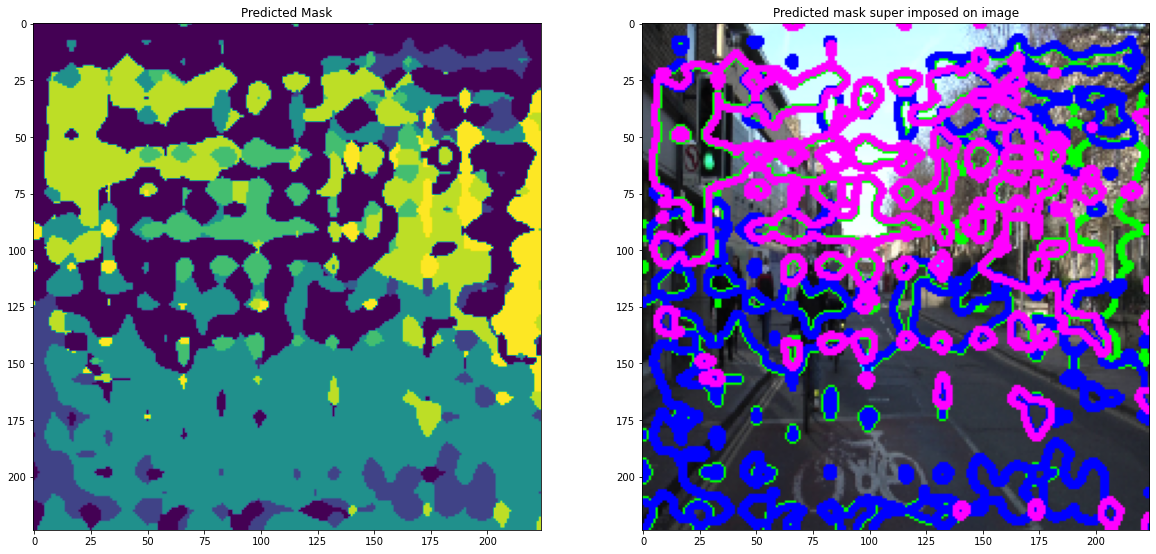

In [70]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_3)
plt.subplot(1, 2, 2)
plt.title('Predicted mask super imposed on image')
show_img_target(img_r, pred_3)

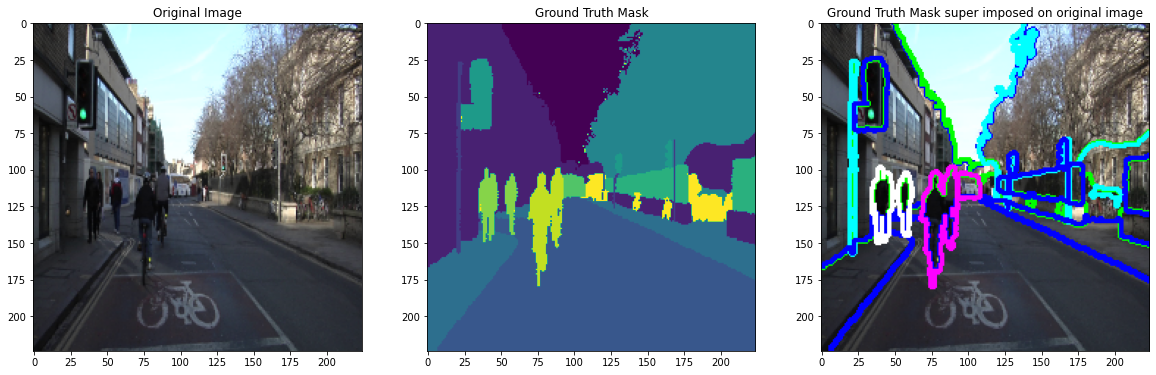

In [71]:
pred_4=get_prediction(img_4)
plt.figure(figsize=(20,20))
img_r= re_normalize(img_4)
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(mask_4)
plt.subplot(1, 3, 3)
plt.title('Ground Truth Mask super imposed on original image')
show_img_target(img_r, mask_4)

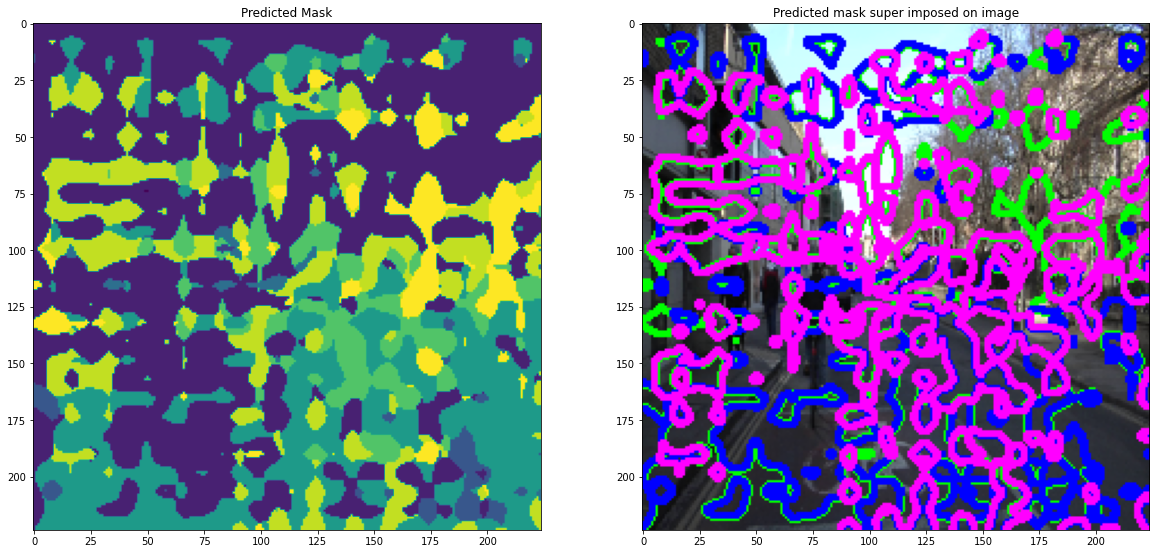

In [72]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_4)
plt.subplot(1, 2, 2)
plt.title('Predicted mask super imposed on image')
show_img_target(img_r, pred_4)